## City Temperature(Univariate 시계열)

In [83]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

### Task: Analyze the rise of temperature over time


#### Global warming is the ongoing rise of the average temperature of the Earth's climate system and has been demonstrated by direct temperature measurements and by measurements of various effects of the warming - Wikipedia

1. Task is to analyze the rise of temperature over time in different parts of the world

2. How much is the temperature increase in different parts of the world over time?

3. Which cities are seeing a rapid increase in temperature over time?

## 1. 데이터 불러오기 및 전처리

In [84]:
base_dir = "C:/city_temperature.csv"
citytemp_data = pd.read_csv(base_dir)

C:\newana\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


- 이렇게 하나의 column에 문자형과 숫자형 데이터가 섞여 있는 경우에 중요한 것은 두 정보를 모두 다룰 수 있는 ColumnTransformer을 이용해서 Pipeline을 설계하여 데이터를 정리하는 것이 매우 중요하다.

- 그리고 연속으로 변화가 주어지는 경우이기 때문에 RNN Model을 설계하여서 LSTM layer을 이용해 이전에 했던 네이버에서 얻은 우리나라 날씨로 24시간 이후의 기후를 예측하는것과 엇비슷하다고 볼 수 있다.

- 예측을 마무리 하면 몇년 단위로 이후의 나라별 기후 예측을 시각화 하고, 그 전에는 나라별로 기후 변화를 시각화하여서 예측을 확인해 보고자 한다.

- 마지막으로 '도시'의 기후 변화 예측이기 때문에 'Region', 'Country', 'State'의 정보는 drop해야 한다.

In [85]:
np.sum(pd.isnull(citytemp_data))

Region                  0
Country                 0
State             1450990
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64

State data는 그냥 없애주기로 하자

In [86]:
citytemp_data.drop('State',axis = 1)

,Region,Country,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,Algiers,1,1,1995,64.2
1,Africa,Algeria,Algiers,1,2,1995,49.4
2,Africa,Algeria,Algiers,1,3,1995,48.8
3,Africa,Algeria,Algiers,1,4,1995,46.4
4,Africa,Algeria,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...
2906322,North America,US,San Juan Puerto Rico,7,27,2013,82.4
2906323,North America,US,San Juan Puerto Rico,7,28,2013,81.6
2906324,North America,US,San Juan Puerto Rico,7,29,2013,84.2
2906325,North America,US,San Juan Puerto Rico,7,30,2013,83.8


In [87]:
citytemp_data['City']

0                       Algiers
1                       Algiers
2                       Algiers
3                       Algiers
4                       Algiers
                   ...         
2906322    San Juan Puerto Rico
2906323    San Juan Puerto Rico
2906324    San Juan Puerto Rico
2906325    San Juan Puerto Rico
2906326    San Juan Puerto Rico
Name: City, Length: 2906327, dtype: object

In [89]:
citytemp_data.values

array([['Africa', 'Algeria', nan, ..., 1, 1995, 64.2],
       ['Africa', 'Algeria', nan, ..., 2, 1995, 49.4],
       ['Africa', 'Algeria', nan, ..., 3, 1995, 48.8],
       ...,
       ['North America', 'US', 'Additional Territories', ..., 29, 2013,
        84.2],
       ['North America', 'US', 'Additional Territories', ..., 30, 2013,
        83.8],
       ['North America', 'US', 'Additional Territories', ..., 31, 2013,
        83.6]], dtype=object)

```dataset이름.values``` 를 호출하면 각 행이 array의 형태로 출력이 된다.

지금 짠 코드와는 별개의 내용이지만 ```dataframe이름['label이름'].plt()``` 하면 시각화를 해주고

```dataframe이름.dropna()``` 를 해주면 비어있는, 즉 NAN의 형태의 데이터가 있는 열을 아얘 없애준다.

In [91]:
citytemp_data.loc

예를 들면
```
split_date = pd.Timestamp('01-01-2017')
#split_data를 기준으로 train, test data 분리
train = df.loc[:split_date, ['trade_price_idx_value']]
test = df.loc[split_date:, ['trade_price_idx_value']]
```
이런 식으로 해주고 변화를 시각화해 보자면 



In [92]:
citytemp_data

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...,...
2906322,North America,US,Additional Territories,San Juan Puerto Rico,7,27,2013,82.4
2906323,North America,US,Additional Territories,San Juan Puerto Rico,7,28,2013,81.6
2906324,North America,US,Additional Territories,San Juan Puerto Rico,7,29,2013,84.2
2906325,North America,US,Additional Territories,San Juan Puerto Rico,7,30,2013,83.8


In [93]:
city_data = citytemp_data.drop(['Region','Country', 'State'], axis = 1)

In [94]:
city_data.head()

,City,Month,Day,Year,AvgTemperature
0,Algiers,1,1,1995,64.2
1,Algiers,1,2,1995,49.4
2,Algiers,1,3,1995,48.8
3,Algiers,1,4,1995,46.4
4,Algiers,1,5,1995,47.9


In [95]:
set(list(city_data["City"].values))

{'Abidjan',
 'Abilene',
 'Abu Dhabi',
 'Addis Ababa',
 'Akron Canton',
 'Albany',
 'Albuquerque',
 'Algiers',
 'Allentown',
 'Almaty',
 'Amarillo',
 'Amman',
 'Amsterdam',
 'Anchorage',
 'Ankara',
 'Antananarivo',
 'Ashabad',
 'Asheville',
 'Athens',
 'Atlanta',
 'Atlantic City',
 'Auckland',
 'Austin',
 'Baltimore',
 'Bangkok',
 'Bangui',
 'Banjul',
 'Barcelona',
 'Baton Rouge',
 'Beijing',
 'Beirut',
 'Belfast',
 'Belgrade',
 'Belize City',
 'Bern',
 'Bilbao',
 'Billings',
 'Birmingham',
 'Bishkek',
 'Bismarck',
 'Bissau',
 'Bogota',
 'Boise',
 'Bombay (Mumbai)',
 'Bonn',
 'Bordeaux',
 'Boston',
 'Brasilia',
 'Bratislava',
 'Brazzaville',
 'Bridgeport',
 'Bridgetown',
 'Brisbane',
 'Brownsville',
 'Brussels',
 'Bucharest',
 'Budapest',
 'Buenos Aires',
 'Buffalo',
 'Bujumbura',
 'Burlington',
 'Cairo',
 'Calcutta',
 'Calgary',
 'Canberra',
 'Capetown',
 'Caracas',
 'Caribou',
 'Casper',
 'Charleston',
 'Charlotte',
 'Chattanooga',
 'Chengdu',
 'Chennai (Madras)',
 'Cheyenne',
 'Chica

## 2. 학습
#### 시계열 RNN학습은 New York City의 데이터만을 이용해서 분석하고자 한다.
그렇게 해도 충분히 데이터 양이 많기 때문에 분석이 가능할 것이다.
다만 여기서 데이터를 조작해야 하는 부분이 Month, Day, Year의 정보를 하나로 합쳐서 date정보로 바꾸어 (Year-Month-Day)를 label로 이용하면 될 것이다.

### 2-1. 데이터 전처리

In [96]:
ny_df = city_data.query("City=='New York City'")

In [97]:
ny_df

,City,Month,Day,Year,AvgTemperature
2291563,New York City,1,1,1995,44.0
2291564,New York City,1,2,1995,41.8
2291565,New York City,1,3,1995,28.1
2291566,New York City,1,4,1995,31.7
2291567,New York City,1,5,1995,21.3
...,...,...,...,...,...
2300823,New York City,5,9,2020,42.2
2300824,New York City,5,10,2020,50.3
2300825,New York City,5,11,2020,55.7
2300826,New York City,5,12,2020,51.1


In [98]:
len(ny_df)

9265

In [99]:
list(ny_df.Month)[0]

1

In [100]:
ny_df.index = [int(i) for i in range(len(ny_df))]
ny_df.head()

,City,Month,Day,Year,AvgTemperature
0,New York City,1,1,1995,44.0
1,New York City,1,2,1995,41.8
2,New York City,1,3,1995,28.1
3,New York City,1,4,1995,31.7
4,New York City,1,5,1995,21.3


In [101]:
date = []
for i in range(len(ny_df)):
    year, month, day = list(ny_df.Year)[i], list(ny_df.Month)[i], list(ny_df.Day)[i]
    d = str(year)+'-'+str(month)+'-'+str(day)
    date.append(d)


In [102]:
date = pd.DataFrame({'date':date})

In [164]:
ny_df = pd.merge(date, ny_df, on = date.index)

In [165]:
ny_df

,key_0,date,City,AvgTemperature
0,0,1995-1-1,New York City,44.0
1,1,1995-1-2,New York City,41.8
2,2,1995-1-3,New York City,28.1
3,3,1995-1-4,New York City,31.7
4,4,1995-1-5,New York City,21.3
...,...,...,...,...
9260,9260,2020-5-9,New York City,42.2
9261,9261,2020-5-10,New York City,50.3
9262,9262,2020-5-11,New York City,55.7
9263,9263,2020-5-12,New York City,51.1


In [106]:
ny_df = ny_df.drop(['key_0'],axis = 1)
ny_df = ny_df.drop(['Day'], axis = 1)
ny_df = ny_df.drop(['Year'], axis = 1)


In [169]:
ny = ny_df.set_index('date')
#ny_df 데이터프레임의 index값을 ny_df['date']로 설정해 주었다.

In [170]:
ny.head()

,key_0,City,AvgTemperature
date,,,
1995-1-1,0,New York City,44.0
1995-1-2,1,New York City,41.8
1995-1-3,2,New York City,28.1
1995-1-4,3,New York City,31.7
1995-1-5,4,New York City,21.3


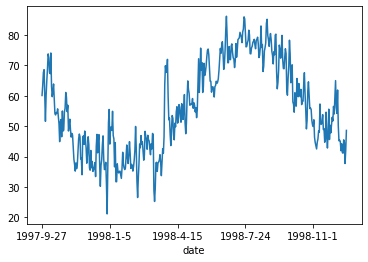

In [184]:
ny['AvgTemperature'][1000:1450].plot()

In [182]:
ny_df.head()

,key_0,date,City,AvgTemperature
0,0,1995-1-1,New York City,44.0
1,1,1995-1-2,New York City,41.8
2,2,1995-1-3,New York City,28.1
3,3,1995-1-4,New York City,31.7
4,4,1995-1-5,New York City,21.3


- 물론 주식 예측과 달리 평균 기온의 경우 특히 사계절이 분명하다면 반복적인 변화가 일정 시간이 지난 후에 일정하기 때문에 학습하고 예측하기가 비교적 쉬울 것이라고 생각한다.

- 시계열 수치와 같은 데이터를 학습시키기 전에 데이터셋을 만들기 위해서는 반드시 데이터를 preprocessing을 제대로 해 주어야 한다. 매 순간 순간의 값이 중요한 것이 아니라 일정 기간동안의 추이가 중요한 것이기 때문이다.

- 이번에는 기후변화라는 한가지 특성만을 예측할 것이기 때문에 num_example의 개수는 1개일 것이다.



- 데이터는 하루에 한개씩 1995년 1월 1일부터 2020년 5월 20일까지 총 9265일동안 기록이 되었다. 
- 특정 날짜가 주어졌을 때 그 이후 200일동안의 기후를 예측하고자 한다.
  - 예측을 하기 위해서는 이전 2년간의 데이터를 사용하도록 한다.
  - 그러면 대략 2년x365일 동안의 관측값이 포함된 데이터를 만들어야 한다.
  - 9265/(2x365)개만큼의 분량이 만들어지기 때문에 솔직히 학습에 충분한 양이라고 보기는 어렵다.

In [279]:
def make_data(dataset, start, end, past, future):
    #past는 학습에 이용할 과거 데이터의 양, future은 예측할 미래의 데이터양
    data, label = [],[]
    start += past
    if end is None:
        end = len(dataset)-future
    for i in range(start, end):
        data.append(np.reshape(dataset[i-past:i],(past, 1)))
        #label에는 예측값이 담겨 있다.
        label.append(dataset[i+future])
    return np.array(data), np.array(label)

In [280]:
temp_data = ny['AvgTemperature']

In [281]:
temp_data

date
1995-1-1     44.0
1995-1-2     41.8
1995-1-3     28.1
1995-1-4     31.7
1995-1-5     21.3
             ... 
2020-5-9     42.2
2020-5-10    50.3
2020-5-11    55.7
2020-5-12    51.1
2020-5-13    51.8
Name: AvgTemperature, Length: 9265, dtype: float64

- temp_data를 정규화(normalization)해줄 필요가 있다
- 정규화하는 가장 일반적인 방법은 (X - E(X))/(V(X)^0.5)로, 데이터에 평균을 뺀 뒤에 분산에 루트를 씌운 값으로 나누는 것이다.
  - 단, 평균과 표준 편차는 훈련 데이터만으로 계산해 주어야 한다.

In [282]:
temp_data = temp_data.values

In [283]:
trainsplit = 6265
train_mean = temp_data[:trainsplit].mean()
train_std = temp_data[:trainsplit].std()
#여기서 조심하자 - temp_data.values값의 전부를 이용하지만 정규화를 위한 수치는 훈련데이터로부터
train_data = (temp_data-train_mean)/train_std

In [284]:
train_data.shape

(9265,)

In [292]:
train_x, train_y = make_data(train_data, 0, trainsplit, 100, 0)
test_x, test_y = make_data(train_data, trainsplit, None, 100, 0)

In [294]:
len(train_x),len(test_x)

(6165, 2900)

In [302]:
for i,j in enumerate([train_x[0],train_y[0]]):
    print(j)

[[-0.5925493 ]
 [-0.70804258]
 [-1.42725071]
 [-1.23826172]
 [-1.78422993]
 [-1.4377501 ]
 [-0.65554564]
 [-1.03877333]
 [-1.09651997]
 [-1.33275621]
 [-1.29075866]
 [-1.03877333]
 [-0.42455908]
 [-0.15157498]
 [ 0.08466127]
 [-0.00458353]
 [-0.26181856]
 [-0.66604503]
 [-0.83928494]
 [-0.63979655]
 [-0.63454686]
 [-1.01252486]
 [-1.1542666 ]
 [-1.02302425]
 [-0.89178189]
 [-0.98102669]
 [-1.10176966]
 [-1.42200102]
 [-1.5374943 ]
 [-1.12801813]
 [-0.98102669]
 [-0.77628861]
 [-0.77103891]
 [-1.55849307]
 [-1.25926049]
 [-1.60574032]
 [-2.31969876]
 [-1.9049729 ]
 [-1.65823727]
 [-1.73173299]
 [-1.17001569]
 [-0.82353586]
 [-1.68973543]
 [-1.89972321]
 [-1.45874888]
 [-1.33800591]
 [-0.80778677]
 [-0.83403525]
 [-0.77628861]
 [-0.77103891]
 [-0.63979655]
 [-0.90228127]
 [-1.04927272]
 [-0.79203769]
 [-0.62929717]
 [-1.26451019]
 [-1.41150163]
 [-1.33800591]
 [-1.07027149]
 [-0.81828616]
 [-1.0650218 ]
 [-1.19101447]
 [-1.04402302]
 [-0.85503402]
 [-0.5925493 ]
 [-0.49805481]
 [-0.14107

### 2-2. 만든 데이터셋 Visualization
이제 시각화를 해보자. test_x의 데이터는 우리가 학습에 이용하는 데이터이고, test_y는 예측하기로 설정된 값이다.

In [315]:
import matplotlib.pyplot as plt
def show(data,limit,title):
    label = ['History','Future', 'Model Prediction']
    time_steps = list(range(-data[0].shape[0],0))
    marker = ['.-','rx','go']
    if limit:
        future = limit
    else:
        future = 0
    for i,x in enumerate(data):
        if i:
            plt.plot(future, data[i], marker[i], label = label[i])
        else:
            plt.plot(time_steps, data[i], marker[i], label = label[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    return plt
    

<module 'matplotlib.pyplot' from 'C:\\newana\\lib\\site-packages\\matplotlib\\pyplot.py'>

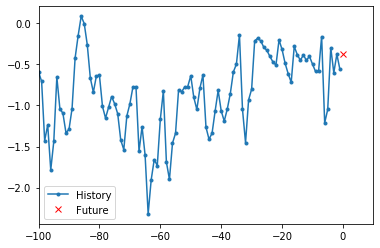

In [316]:
show([train_x[0], train_y[0]], 0, 'test')

### 2-3. Baseline 만들기
- 모델을 만들기 전에 baseline, 즉 기준이 필요한데, 이는 이 경우에는 학습에 이용한 과거 데이터의 값의 평균으로 정의하도록 한다.
- RNN모델로 학습을 한 이후에 baseline으로 정한 기준에 미칠지 못 미칠지 확인해 주어야 한다.

In [317]:
def baseline(history):
    return np.mean(history)

In [318]:
baseline(train_x[0])

-0.863591026218229

<module 'matplotlib.pyplot' from 'C:\\newana\\lib\\site-packages\\matplotlib\\pyplot.py'>

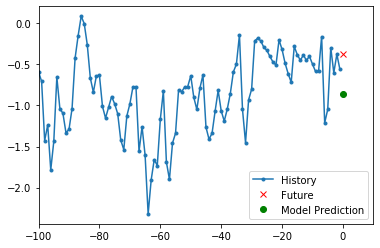

In [319]:
show([train_x[0], train_y[0], baseline(train_x[0])],0,'Try')

### 3. RNN Model 만들기
- LSTM Layer을 이용할 것인데, 해당 Layer이 input data로서  
inputs: A 3D tensor with shape [batch, timesteps, feature] 밖에 안된다

In [372]:
batch = 128
buffer = 10000
train = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train = train.shuffle(buffer).batch(batch).repeat()

test = tf.data.Dataset.from_tensor_slices((test_x, test_y))
test = test.batch(batch).repeat()

In [373]:
train_x.shape

(6165, 100, 1)

In [374]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(100, input_shape = (100,1), return_sequences = True))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dense(1))

In [375]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [378]:
model.compile(loss = 'mean_squared_error',
             optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
             metrics = ['accuracy'])

In [379]:
history = model.fit(train, steps_per_epoch = 200, validation_data = test, validation_steps = 50, epochs = 10)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 190s 949ms/step - loss: 0.3403 - accuracy: 0.0000e+00 - val_loss: 0.1353 - val_accuracy: 0.0000e+00
Epoch 2/10
200/200 [==============================] - 188s 938ms/step - loss: 0.3228 - accuracy: 0.0000e+00 - val_loss: 0.1284 - val_accuracy: 0.0000e+00
Epoch 3/10
200/200 [==============================] - 193s 966ms/step - loss: 0.3130 - accuracy: 0.0000e+00 - val_loss: 0.1171 - val_accuracy: 0.0000e+00
Epoch 4/10
200/200 [==============================] - 194s 971ms/step - loss: 0.2971 - accuracy: 0.0000e+00 - val_loss: 0.1048 - val_accuracy: 0.0000e+00
Epoch 5/10
200/200 [==============================] - 194s 971ms/step - loss: 0.2781 - accuracy: 0.0000e+00 - val_loss: 0.0975 - val_accuracy: 0.0000e+00
Epoch 6/10
200/200 [==============================] - 197s 984ms/step - loss: 0.2877 - accuracy: 0.0000e+00 - val_loss: 0.0902 - val_accuracy: 0.0000e+00
Epoch 7/10
200/200 [=============

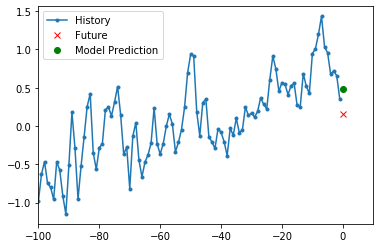

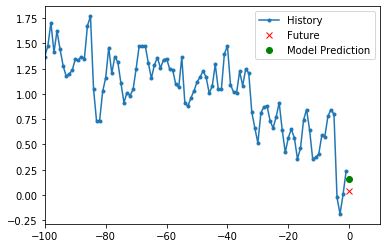

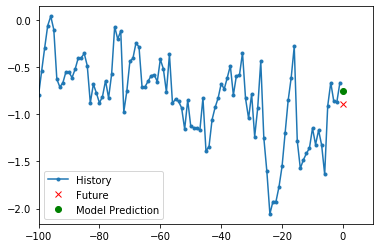

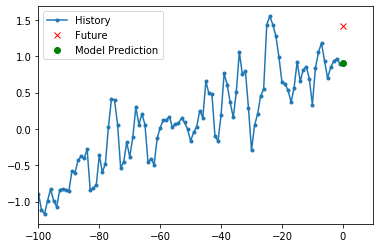

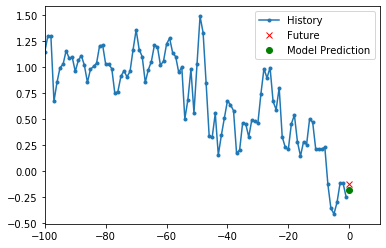

In [380]:
for x,y in test.take(5):
    plot = show([x[0].numpy(), y[0].numpy(), model.predict(x)[0]],0,'Model Accuracy Test')
    plot.show()